# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [153]:
%matplotlib notebook
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import matplotlib.dates as dates

In [154]:
df=(pd.read_csv("data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv")
    .sort_values(by=["ID","Date"])
    )

In [155]:
# separate month and year + delete leap years
df["Y"]=df["Date"].apply(lambda x: x[:4])
df["M_D"]=df["Date"].apply(lambda x: x[5:])

df=df[df["M_D"]!="02-29"]

df["M_D"]=pd.to_datetime(df["M_D"],box=False,format="%m-%d")
#df["Data_Value"] = df['Data_Value']/10.0


In [156]:
# Max and Min Temp 10 year record

temp_min=(df[(df["Element"]=="TMIN") & (df["Y"]!="2015")]
          .drop(["ID","Date","Element","Y"],1)
          .groupby("M_D")["Data_Value"].aggregate({"min":np.mean})
          .reset_index()
         )

temp_max=(df[(df["Element"]=="TMAX") & (df["Y"]!="2015")]
          .drop(["ID","Date","Element","Y"],1)
          .groupby("M_D")["Data_Value"].aggregate({"max":np.mean})
          .reset_index()
         )
# merge min and max
temp=pd.merge(temp_min,temp_max)
temp["M_D"]=temp["M_D"].apply(lambda x: dates.date2num(x))
temp["min"] = temp['min']/10.0
temp["max"] = temp['max']/10.0


In [157]:
# max and min for 2015

temp_min15=(df[(df["Element"]=="TMIN") & (df["Y"]=="2015")]
          .drop(["ID","Date","Element","Y"],1)
          .groupby("M_D")["Data_Value"].aggregate({"min15":np.min})
          .reset_index()
          #.set_index("M_D")
            )

temp_max15=(df[(df["Element"]=="TMAX") & (df["Y"]=="2015")]
          .drop(["ID","Date","Element","Y"],1)
          .groupby("M_D")["Data_Value"].aggregate({"max15":np.max})
          .reset_index()
          #.set_index("M_D")
            )
# merge min and max
temp15=pd.merge(temp_min15,temp_max15)
temp15["M_D"]=temp15["M_D"].apply(lambda x: dates.date2num(x))
temp15["min15"] = temp15['min15']/10.0
temp15["max15"] = temp15['max15']/10.0



In [158]:
# final merge, check when in 2015 10yr-historical min/max was broken --> add col
foo=pd.merge(temp,temp15,how="outer", left_on="M_D",right_on="M_D")
foo['min_record_2015'] = foo['min15'] < foo['min']
foo['max_record_2015'] = foo['max15'] > foo['max']

foo=foo[(foo.min_record_2015 == True) | (foo.max_record_2015 == True)] #remove false|false rows

#make df containig only low high val
low_high=foo.apply(lambda x: x["min15"] if x["min_record_2015"] else x["max15"] , axis=1) #


<IPython.core.display.Javascript object>


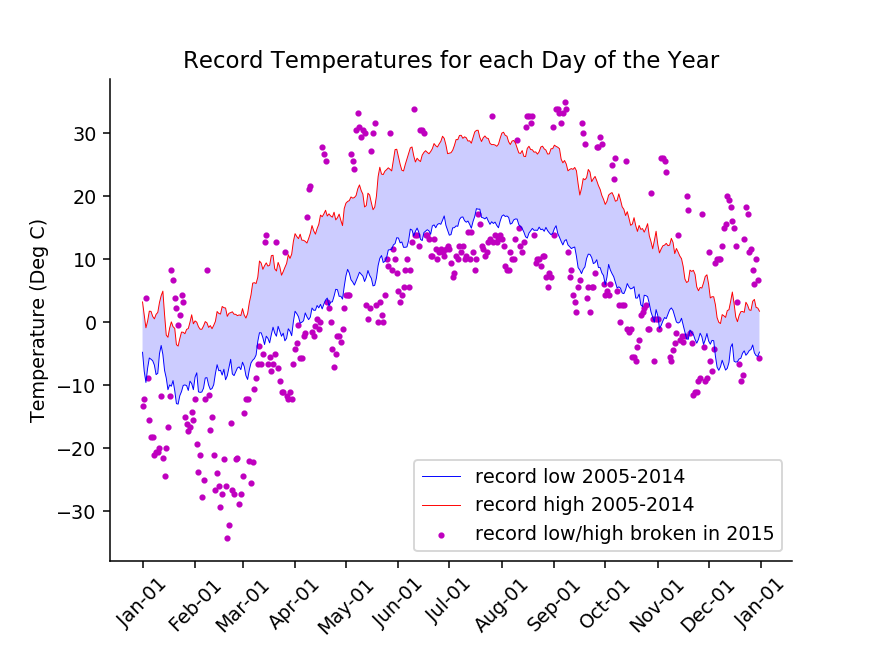

In [159]:
%matplotlib notebook
plt.close()
plt.figure()

#historical line plot
plt.plot(temp_min["M_D"], temp_min["min"]/10, c="b", lw=0.5, label="record low 2005-2014")
plt.plot(temp_max["M_D"], temp_max["max"]/10 ,c="r", lw=0.5, label="record high 2005-2014")

#scatter of broken min/max temp in 2015
plt.scatter(foo["M_D"], low_high, c="m", marker="o", s=5, label="record low/high broken in 2015")

#(foo.assign(y=np.where(foo['min_record_2015'], foo['min15'], foo['max15'])).plot.scatter('M_D', 'y'))

ax = plt.gca()
ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%d'))
ax.xaxis.set_major_locator(dates.MonthLocator())
loc, labels = plt.xticks()
plt.setp(labels, rotation=45)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.subplots_adjust(bottom=0.15)
plt.legend(loc='best')
plt.ylabel('Temperature [°C]')
plt.title('Record Temperatures for each Day of the Year')

plt.gca().fill_between(temp['M_D'], 
                       temp['min'], temp['max'], 
                       facecolor='blue', 
                       alpha=0.20)
#plt.savefig("test.png")
plt.show()